In [43]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import exposure
from nilearn import plotting
%matplotlib inline
import csv
import torch
import gzip
from src.unet.loss import MixedLoss
import torch
from matplotlib import image

In [2]:
train_info_path = "../data/ribfrac-challenge/validation/ribfrac-val-info.csv"

label_map = {}
with open(train_info_path, newline="") as f:
    reader = csv.DictReader(f, delimiter=",")
    for row in reader:
        public_id = row["public_id"]
        label_id = int(row["label_id"])
        code = int(row["label_code"])

        if public_id not in label_map:
            label_map[public_id] = {}

        label_map[public_id][label_id] = code

In [3]:
public_id = 'RibFrac421'

In [4]:
labels = nib.load(f'../data/ribfrac-challenge/validation/ribfrac-val-labels/{public_id}-label.nii.gz').get_fdata()
labels = torch.tensor(labels, dtype=torch.long)
labels = labels.apply_(label_map[public_id].get) + 1
labels = labels.permute(2, 0 ,1) # (N, H, W)

In [5]:
labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=6)
labels_one_hot = labels_one_hot.type(torch.int8).permute(0, 3, 1, 2)

In [6]:
img = nib.load(f'../data/ribfrac-challenge/validation/ribfrac-val-images/{public_id}-image.nii.gz').get_fdata()

In [7]:
prediction = np.load(f'../inference-results/{public_id}-image-prediction.npy')

In [8]:
bin_probs = np.load(f'../inference-results/{public_id}-image-bin-probs.npy')

In [9]:
probs =  np.load(f'../inference-results/{public_id}-image-probs.npy')
probs = torch.tensor(probs)
print(probs.shape)

torch.Size([325, 6, 512, 512])


# Binary DICE

In [10]:
mixed_loss = MixedLoss()
binary_dice = mixed_loss.get_binary_dice_score(probs, labels, labels_one_hot)
print(binary_dice.mean())

tensor(0.4757)


In [11]:
print("label image shape:", prediction.shape)

label image shape: (512, 512, 325)


In [12]:
print(labels.min())
print(labels.max())


tensor(0)
tensor(2)


In [13]:
img.shape

(512, 512, 325)

In [14]:
print(labels.unique())

tensor([0, 1, 2])


In [15]:
print(np.unique(prediction))

[1. 2. 3. 4.]


In [16]:
#plt.hist(prediction[prediction != 1].flatten())

In [17]:
#plt.hist(bin_probs.flatten(), bins=20)

In [18]:
#plt.hist(probs.flatten(), bins=20)

In [19]:
#print(bin_probs.max())

In [20]:
# print(bin_probs.min())

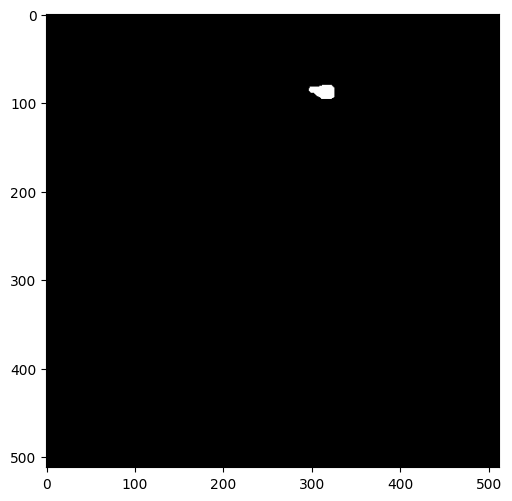

In [21]:
plt.figure(figsize = (6,6), dpi=100) 
labels_plt = np.max(labels.permute(1, 2, 0).numpy() > 1, axis=-1)
plt.imshow(labels_plt, cmap=plt.cm.gray) 


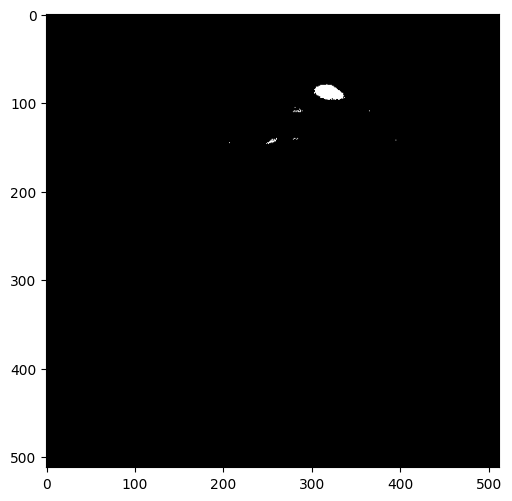

In [22]:
# plot probs
plt.figure(figsize = (6,6), dpi=100) 
combined_slices = np.max(bin_probs > 0.99, axis=-1)
plt.imshow(combined_slices, cmap=plt.cm.gray) 

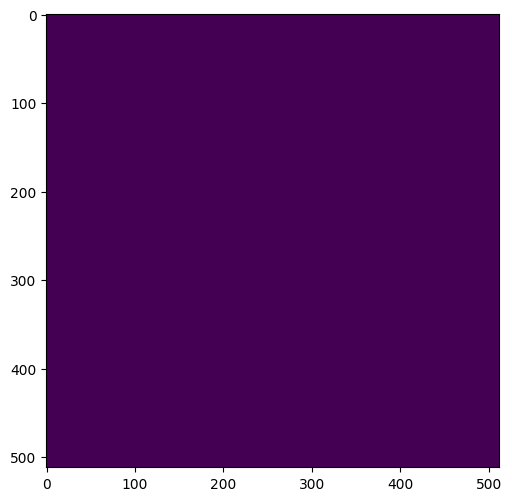

In [39]:
# plot probs
plt.figure(figsize = (6,6), dpi=100) 
plt.imshow(bin_probs[:, :, 50] > 0.01) 

(512, 512, 325)
(512, 512)


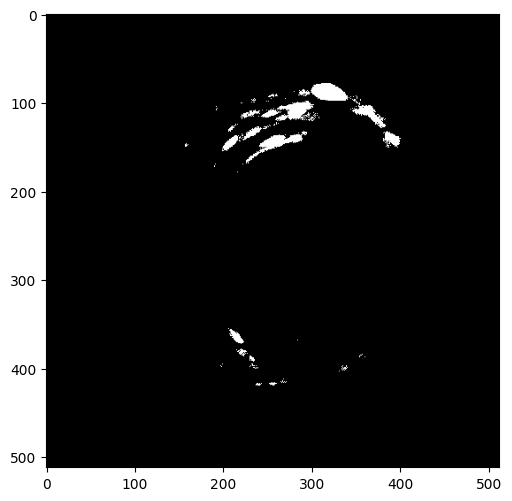

In [24]:
plt.figure(figsize = (6,6), dpi=100) 
print(prediction.shape)
combined_slices = np.max(prediction > 1, axis=-1)
print(combined_slices.shape)
plt.imshow(combined_slices, cmap=plt.cm.gray) 

In [25]:
x = labels.clone()
x[x <= 1] = 0
x[x > 1] = 1
frac_counts = x.sum(dim=(1,2))
frac_counts.shape
np.argsort(frac_counts.numpy())[-10:]

array([146, 137, 145, 144, 143, 138, 142, 139, 140, 141])

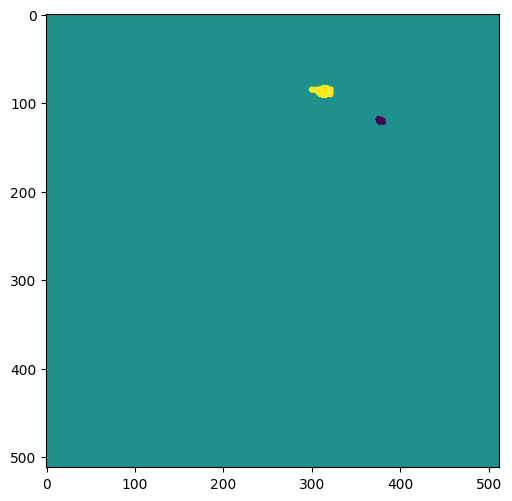

In [26]:
plt.figure(figsize = (6,6), dpi=100) 
plt.imshow(labels.numpy()[141])

In [27]:
prediction.shape

(512, 512, 325)

In [28]:
def plot_img_preds_labels(slice):
    img[img < -0.25] = -1

    x = labels.clone()
    x[x <= 1] = 0
    
    y = prediction[:, :, slice]

    # plt.figure(figsize = (9,6), dpi=100)
    plt.axis('off')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,10))
    
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    plt.subplots_adjust(wspace=0.01)

    for i, ax in enumerate((ax1, ax2, ax3)):
        ax.text(-0.0, 1.02, 'ABC'[i] + ')', transform=ax.transAxes, 
                size=15, weight='normal')
        ax.set_aspect('equal')
    ax1.imshow(img[:, :, slice])
    ax2.imshow(y)
    ax3.imshow(x[slice])
    
    fig.show()

/tmp/ipykernel_89557/3541866028.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


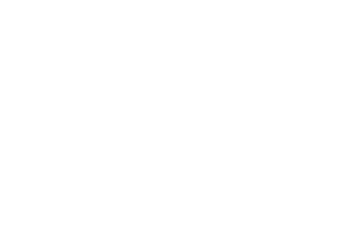

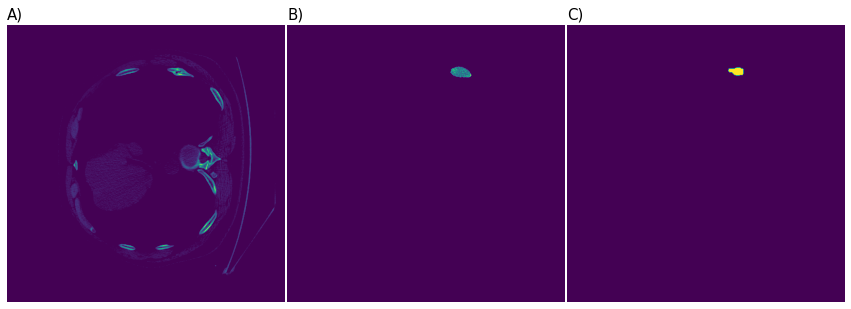

In [29]:
plot_img_preds_labels(141)

In [58]:
def plot_roc():
    img1 = image.imread('../roc_no_reweight.png')
    img2 = image.imread('../roc_with_reweight.png')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,10))
    
    ax1.axis('off')
    ax2.axis('off')
    plt.subplots_adjust(wspace=-0.05)

    for i, ax in enumerate((ax1, ax2)):
        ax.text(0.05, 0.95, 'AB'[i] + ')', transform=ax.transAxes, 
                size=15, weight='normal')
        ax.set_aspect('equal')
    ax1.imshow(img1)
    ax2.imshow(img2)
    

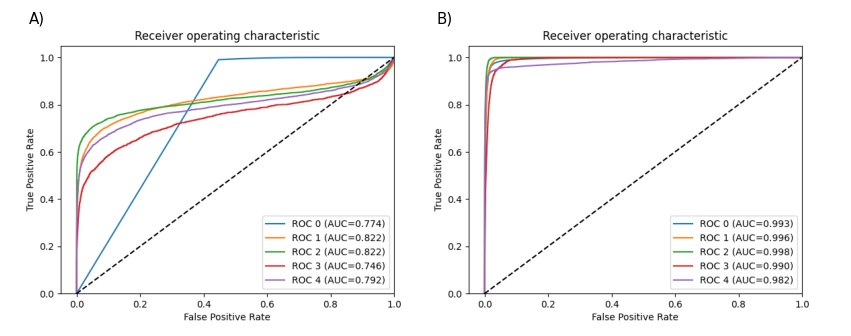

In [59]:
plot_roc()